In [2]:
# Cell 1 — Imports and configuration
# If you want to use absolute Windows path, set DATA_DIR to your path string below.
# Example: DATA_DIR = r"D:\Big Data Alzheimer Prediction Project\Alzheimer-Prediction-System\outputs\preprocessed"
DATA_DIR = None

import warnings
warnings.simplefilter("ignore")

import os
from pathlib import Path
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

# Paths: if DATA_DIR provided (absolute), use it, else assume notebook is in notebooks/ and use repo-relative
if DATA_DIR:
    PREP_DIR = Path(DATA_DIR)
    REPO_ROOT = PREP_DIR.parent.parent  # expect outputs/preprocessed structure
else:
    # when running this notebook from notebooks/ folder:
    REPO_ROOT = Path("..").resolve()
    PREP_DIR = REPO_ROOT / "outputs" / "preprocessed"

MODELS_DIR = REPO_ROOT / "outputs" / "models"
RESULTS_DIR = REPO_ROOT / "outputs" / "model_results"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Using PREP_DIR:", PREP_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


Using PREP_DIR: C:\Users\Isha Singh\Desktop\Alzheimer-Prediction-System-main\outputs\preprocessed
MODELS_DIR: C:\Users\Isha Singh\Desktop\Alzheimer-Prediction-System-main\outputs\models
RESULTS_DIR: C:\Users\Isha Singh\Desktop\Alzheimer-Prediction-System-main\outputs\model_results


In [3]:
# Cell 2 — Load preprocessed data (pickles)
required_files = [
    "X_train.pkl", "X_val.pkl", "X_test.pkl",
    "y_train.pkl", "y_val.pkl", "y_test.pkl"
]
missing = [f for f in required_files if not (PREP_DIR / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing preprocessed files in {PREP_DIR}: {missing}")

X_train = pd.read_pickle(PREP_DIR / "X_train.pkl")
X_val   = pd.read_pickle(PREP_DIR / "X_val.pkl")
X_test  = pd.read_pickle(PREP_DIR / "X_test.pkl")
y_train = pd.read_pickle(PREP_DIR / "y_train.pkl")
y_val   = pd.read_pickle(PREP_DIR / "y_val.pkl")
y_test  = pd.read_pickle(PREP_DIR / "y_test.pkl")

print("Loaded datasets.")
print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)
print("Train class distribution:")
print(pd.Series(y_train).value_counts())


Loaded datasets.
Shapes -> train: (1944, 14) val: (417, 14) test: (417, 14)
Train class distribution:
1    972
0    972
Name: count, dtype: int64


In [5]:
# Cell 3 — Evaluation helper
def evaluate_model(model, X, y, name="set"):
    start_pred = time.time()
    y_pred = model.predict(X)
    end_pred = time.time()
    metrics = {
        "accuracy": float(accuracy_score(y, y_pred)),
        "precision": float(precision_score(y, y_pred, average="binary" if len(np.unique(y))==2 else "macro", zero_division=0)),
        "recall": float(recall_score(y, y_pred, average="binary" if len(np.unique(y))==2 else "macro", zero_division=0)),
        "f1": float(f1_score(y, y_pred, average="binary" if len(np.unique(y))==2 else "macro", zero_division=0)),
        "prediction_time_s": float(end_pred - start_pred)
    }
    # Add ROC-AUC for binary (use probabilities)
    if hasattr(model, "predict_proba") and len(np.unique(y)) == 2:
        try:
            proba = model.predict_proba(X)[:, 1]
            metrics["roc_auc"] = float(roc_auc_score(y, proba))
        except Exception:
            metrics["roc_auc"] = None
    print(f"\n{name} evaluation:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")
    print("\nClassification report:\n", classification_report(y, y_pred, zero_division=0))
    return metrics, (proba if "proba" in locals() else None)


In [6]:
# Cell 4 — Configure model and run GridSearchCV (training)
# You can change param_grid below like you did for DecisionTree.

lr = LogisticRegression(max_iter=5000, solver="liblinear")  # liblinear supports l1/l2
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_choice = "f1" if len(np.unique(y_train)) == 2 else "accuracy"
print("GridSearch scoring:", scoring_choice)

gs = GridSearchCV(
    lr,
    param_grid,
    cv=cv,
    scoring=scoring_choice,
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
gs.fit(X_train, y_train)
train_time = time.time() - start_time

print("\nGrid search done.")
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)
best_model = gs.best_estimator_


GridSearch scoring: f1
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Grid search done.
Best params: {'C': 1, 'class_weight': None, 'penalty': 'l1'}
Best CV score: 0.8023448029445619



Validation evaluation:
  accuracy: 0.8081534772182254
  precision: 0.8
  recall: 0.8229665071770335
  f1: 0.8113207547169812
  prediction_time_s: 0.003187417984008789
  roc_auc: 0.8914243651085756

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       208
           1       0.80      0.82      0.81       209

    accuracy                           0.81       417
   macro avg       0.81      0.81      0.81       417
weighted avg       0.81      0.81      0.81       417


Test evaluation:
  accuracy: 0.7937649880095923
  precision: 0.7675438596491229
  recall: 0.8413461538461539
  f1: 0.8027522935779816
  prediction_time_s: 0.0014843940734863281
  roc_auc: 0.867891976444608

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.78       209
           1       0.77      0.84      0.80       208

    accuracy                           0.79       417


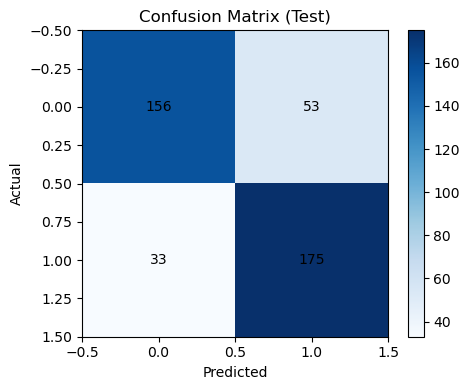

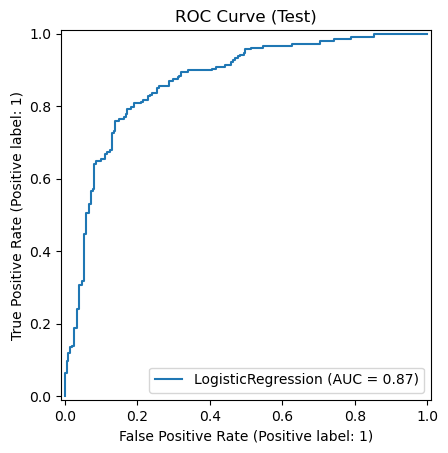

In [7]:
# Cell 5 — Evaluate on validation and test sets, show confusion matrix and ROC (if binary)
val_metrics, _ = evaluate_model(best_model, X_val, y_val, name="Validation")
test_metrics, test_proba = evaluate_model(best_model, X_test, y_test, name="Test")

# Confusion matrix (test)
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center", color="black")
plt.colorbar()
plt.tight_layout()
plt.show()

# ROC curve for binary
if hasattr(best_model, "predict_proba") and len(np.unique(y_test))==2:
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.title("ROC Curve (Test)")
    plt.show()


In [8]:
# Cell 6 — Save artifacts: model, coefficients, summary JSON/CSV, confusion image
# Save model
model_file = MODELS_DIR / "logistic_pipeline.joblib"
joblib.dump(best_model, model_file)
print("Saved model to:", model_file)

# Save coefficients (handle multiclass)
try:
    coef_arr = best_model.coef_
    if coef_arr.ndim == 1 or coef_arr.shape[0] == 1:
        coefs = pd.Series(coef_arr.ravel(), index=X_train.columns)
        coefs = coefs.reindex(X_train.columns)  # ensure alignment
        coefs = coefs.sort_values(key=lambda s: s.abs(), ascending=False)
        coefs.to_csv(RESULTS_DIR / "logistic_coefficients.csv", header=["coefficient"])
        print("Saved coefficients CSV.")
    else:
        coef_df = pd.DataFrame(coef_arr.T, index=X_train.columns)
        try:
            classes = best_model.classes_
            coef_df.columns = [f"coef_class_{c}" for c in classes]
        except Exception:
            coef_df.columns = [f"coef_class_{i}" for i in range(coef_df.shape[1])]
        coef_df.to_csv(RESULTS_DIR / "logistic_coefficients_multiclass.csv")
        print("Saved multiclass coefficients CSV.")
except Exception as e:
    print("Could not save coefficients:", e)

# Save metrics summary (JSON and CSV)
summary = {
    "model": "LogisticRegression",
    "best_params": gs.best_params_,
    "grid_search_time_s": float(train_time),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics,
    "train_shape": list(X_train.shape),
    "val_shape": list(X_val.shape),
    "test_shape": list(X_test.shape)
}
(pd.Series(summary)).to_json(RESULTS_DIR / "logistic_training_summary.json")
metrics_df = pd.DataFrame([{"split": "validation", **val_metrics}, {"split": "test", **test_metrics}])
metrics_df.to_csv(RESULTS_DIR / "logistic_metrics_summary.csv", index=False)
print("Saved metrics summary and CSV.")

# Save confusion matrix image
import matplotlib
matplotlib.use("Agg")  # safe save
import matplotlib.pyplot as plt
cm_fig = plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha="center", va="center", color="black")
plt.colorbar()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "logistic_confusion_matrix.png", dpi=200)
plt.close(cm_fig)
print("Saved confusion matrix image to results.")


Saved model to: C:\Users\Isha Singh\Desktop\Alzheimer-Prediction-System-main\outputs\models\logistic_pipeline.joblib
Saved coefficients CSV.
Saved metrics summary and CSV.
Saved confusion matrix image to results.
